In [2]:
!pip install pandas seaborn matplotlib scikit-learn gensim eli5 tiktoken spacy gensim wordcloud datasets

In [3]:
import tiktoken
import pandas as pd
import numpy as np
import nltk

import matplotlib.pyplot as plt
from datasets import load_dataset
from gensim.models import Word2Vec, KeyedVectors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from nltk import word_tokenize, sent_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Dataset loading

In [4]:
dataset = load_dataset("yaful/DeepfakeTextDetect")

# Load the train dataset
df = dataset["train"].to_pandas()
df.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,text,label,src
0,White girls very rarely date Asian men. Even i...,1,cmv_human
1,I am a 23 year old male Indian American male. ...,1,cmv_human
2,"Take three people, Persons A, B, and C. They l...",1,cmv_human
3,(A) Work part-time in high school; Then go to ...,1,cmv_human
4,When police introduce a new form of speed prev...,1,cmv_human


Text(0.5, 1.0, 'Data Distribution')

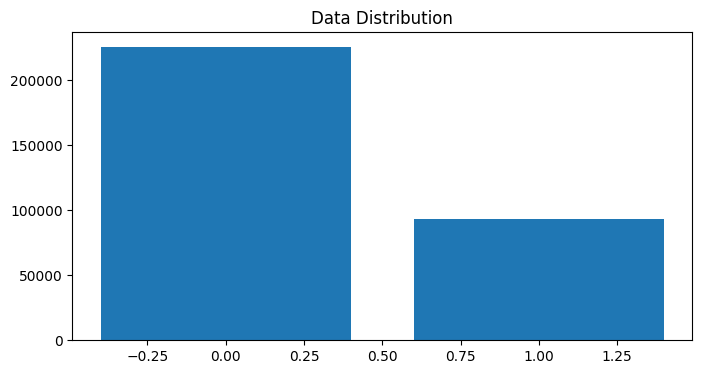

In [5]:
val_count = df.label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Data Distribution")

## Preprocessing

In [6]:
def preprocess_text(text):
    # Text to lowercase
    text = text.lower()

    list_text = text.split()

    # Remove stopwords
    list_stopwords = set(nltk.corpus.stopwords.words("english"))
    list_text = [word for word in list_text if word not in list_stopwords]

    # Lemmetize
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    list_text = [lem.lemmatize(word) for word in list_text]

    text = " ".join(list_text)
    return text

In [7]:
# Check if df.pkl exists
try:
    df = pd.read_pickle("df.pkl")
except:
    df["text_preprocess"] = df["text"].apply(lambda x: preprocess_text(x))
    df.to_pickle("df.pkl")

In [8]:
# Save time when retry new model
if "df" not in locals():
    df = pd.read_pickle("df.pkl")

## Training a classifier

In [9]:
def document_vector(doc, wv):
    """Create document vectors by averaging word vectors."""
    words = word_tokenize(doc)
    word_vectors = np.array([wv[word] for word in words if word in wv])

    if len(word_vectors) == 0:
        return np.zeros(wv.vector_size)
    return np.mean(word_vectors, axis=0)

In [10]:
X = df["text_preprocess"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
print(f"Features dimension: {X_train.shape}")

Features dimension: (255256,)


In [11]:
classifier = make_pipeline(TfidfVectorizer(max_features=10000, ngram_range=(1,2), lowercase=False), TfidfTransformer(), LogisticRegression(random_state=42, class_weight='balanced', penalty = 'l2', max_iter = 1000))

In [12]:
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84     45073
           1       0.61      0.76      0.68     18742

    accuracy                           0.79     63815
   macro avg       0.75      0.78      0.76     63815
weighted avg       0.81      0.79      0.79     63815



## Plot confusion matrix

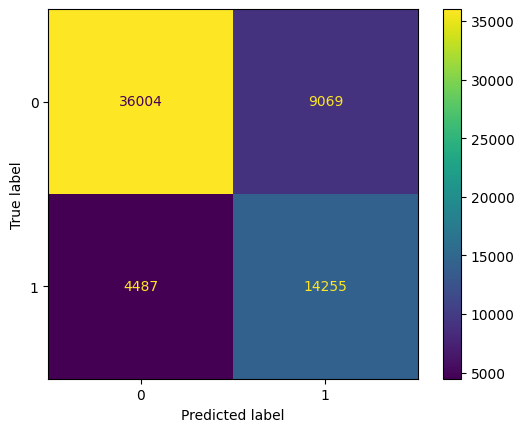

In [13]:
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=[0,1])
disp.plot()
plt.show()

## Optimize hyperparameters using Grid Search

In [15]:
model = make_pipeline(TfidfVectorizer(max_features=10000, ngram_range=(1,2), lowercase=False), TfidfTransformer(), LogisticRegression(random_state=42, class_weight='balanced', penalty='l1', max_iter=1000, solver='liblinear'))

param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Test set score:", test_score)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'logisticregression__C': 1}
Best cross-validation score: 0.7581703370406102
              precision    recall  f1-score   support

           0       0.89      0.80      0.84     45073
           1       0.61      0.76      0.68     18742

    accuracy                           0.79     63815
   macro avg       0.75      0.78      0.76     63815
weighted avg       0.81      0.79      0.79     63815

Test set score: 0.7864922040272663
